# Gaussian Process Regression

Primero, importamos los paquetes necesarios y cargamos los datos en un dataframe

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

#evaluation metrics
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as r2

#Scaler y GPR
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor

#kernels
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RBF
# cargamos el dataset
dataset = pd.read_csv('dataset.csv', encoding='utf-8',skiprows=lambda x: (x != 0) and not x % 2)

#Guardamos los datos importantes en un dataset
d = {'LV ActivePower (kW)': dataset['LV ActivePower (kW)'] , 'Wind Speed (m/s)': dataset['Wind Speed (m/s)'],'Wind Direction (°)': dataset['Wind Direction (°)']}
df = pd.DataFrame(data = d)

In [1]:
# Formatea las variables de tal forma que las pueda admitir el algoritmo
def fix_parameters(X, m, delta):
    left_stop = (m + delta)
    tam = X.size - left_stop
    i = X.size - 1
    X_fixed = []
    y_fixed = []
    while i >= left_stop:
        X_fixed = np.append(X_fixed, X[(i + 1 - left_stop):(i + 1) - delta])
        y_fixed = np.append(y_fixed, X[i])
        i = i - 1
    X_fixed = np.reshape(X_fixed, (tam, m))
  
    return X_fixed, y_fixed

In [3]:
def best_param():
    best_alpha = -1
    best_error = 10
    First = True
    alphas = np.arange(1, 20, 3)
    for a in alphas:
        gpr = GaussianProcessRegressor(kernel =RBF(length_scale = 50) , alpha =a , random_state=0).fit(X_train_fixed,y_train_fixed)
        pred = gpr.predict(X_test_fixed)
        error = mean_squared_error(scaler.inverse_transform(y_test_fixed.reshape(-1,1)), scaler.inverse_transform(pred.reshape(-1,1)), squared= False)
        print("ALPHA:")
        print(a)
        print(error)
        if error < best_error or First:
            if First == True: First = False
            best_error = error
            best_alpha = a
            
    return best_alpha

Seleccionamos una columna con la que trabajar. Basta con descomentar una de las tres líneas de código a continuación

In [4]:
X = df['LV ActivePower (kW)'].to_numpy()
#X = df['Wind Direction (°)'].to_numpy()
#X = df['Wind Speed (m/s)'].to_numpy()

Dividimos los datos en entrenamiento y testeo

In [5]:
X_train, X_test = train_test_split(X, test_size=0.4,shuffle=False)

Escalamos los datos

In [6]:
scaler = StandardScaler() 
scaler.fit(X_train.reshape(-1,1))
X_train_scaled=scaler.transform(X_train.reshape(-1,1))
X_test_scaled=scaler.transform(X_test.reshape(-1,1))

A continuación, formateamos los datos de manera que puedan ser introducidos en el regresor. Para ello establecemos una m, que consiste en la cantidad de datos de entrenamiento que queramos utilizar, y una delta, que es el tiempo a futuro que queremos predecir. Tras eso, simplemente tenemos que llamar a la función definida previamente "fix_parameters" que devuelve una matriz y un array listos para ser usados.

In [7]:
#1 hora = 3
#6 horas = 18
#12 horas = 36
#1 día = 72
#3 días = 216
#1 semana = 504
m = 72
delta = 18
X_train_fixed, y_train_fixed = fix_parameters(X_train_scaled, m, delta)
X_test_fixed, y_test_fixed = fix_parameters(X_test_scaled, m, delta)

Utilizando la función definida previamente, best_param(), que devuelve la alpha con mejores resultados para el modelo, hallamos el mejor valor para el parámetro antes de entrenar nuestro algoritmo.

In [8]:
alpha = best_param()

ALPHA:
1
941.213146744608
ALPHA:
4
942.2647534038816
ALPHA:
7
947.1945510688114
ALPHA:
10
951.1568997034894
ALPHA:
13
954.5799247337421
ALPHA:
16
957.6463305977617
ALPHA:
19
960.453373618005


In [9]:
print(alpha)

1


Entrenamos el GPR y predecimos los datos de testeo

In [10]:
#Tras probar numerosos kernels, optamos por las dos siguientes opciones
#RBF(length_scale = 50)
#Matern(nu=0.6,length_scale = 100)
gpr = GaussianProcessRegressor(kernel =RBF(length_scale = 50),alpha = alpha, random_state=0).fit(X_train_fixed,y_train_fixed)
pred = gpr.predict(X_test_fixed)

Observamos los resultados en una gráfica

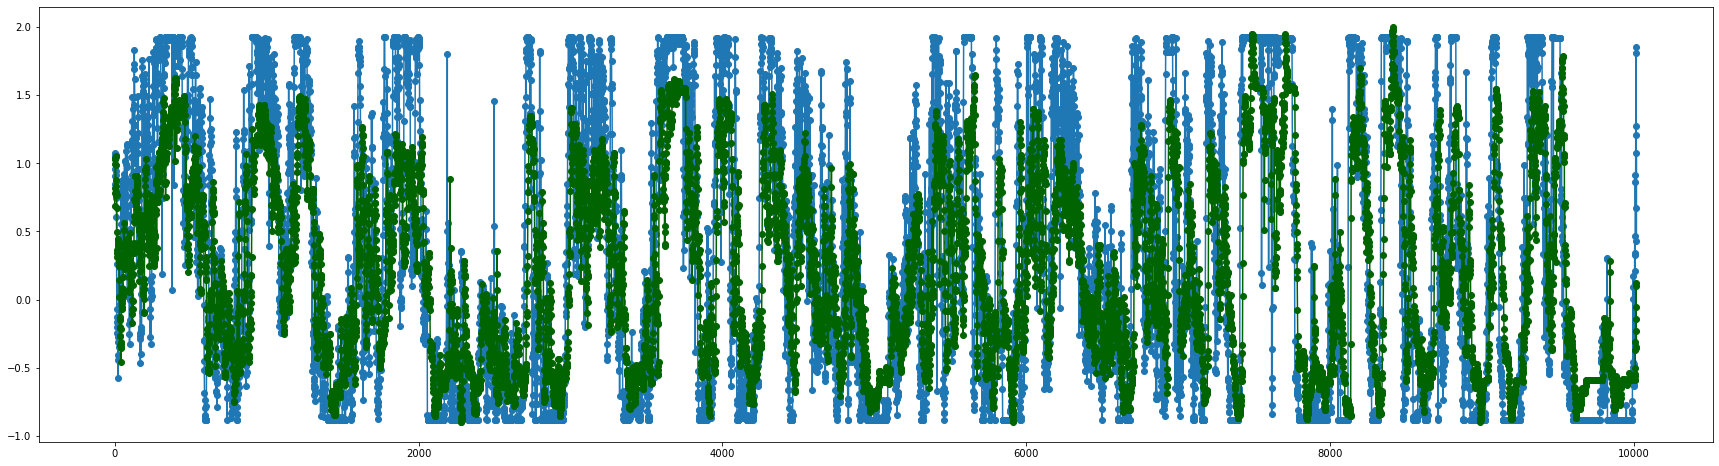

In [11]:
import numpy as np
from matplotlib import pyplot as plt 


fig,ax = plt.subplots(figsize=(30,8))

# training data 
#ax.plot(range(y_train_fixed.size),X_train[504+18:],'navy',marker='o',label='observed')
#ax.plot(X_training[m:],pred_train,'pink',marker='o',label='pred_train')

# test data y predicción
ax.plot(range(y_test_fixed.size),np.flip(y_test_fixed),marker='o')
ax.plot(range(pred.size),np.flip(pred.reshape(-1,1)),'darkgreen',marker='o',label='pred')

Podemos observar la evolución del error en una gráfica:

In [12]:
list_error = np.empty(len(pred))

#invertimos el escalado para comprobar cuánto se alejan realmente las predicciones de los datos reales
pred_error = scaler.inverse_transform(pred.reshape(-1,1))
y_error = scaler.inverse_transform(y_test_fixed.reshape(-1,1))

for i in range (len(pred)):
  list_error[i] = abs(pred_error[i]-y_error[i])

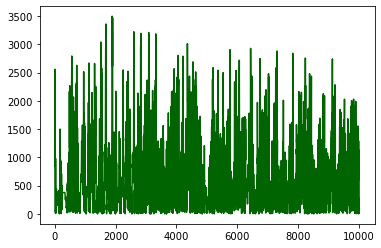

In [13]:
plt.plot(range(pred.size),list_error, 'darkgreen')

Comprobamos la efectividad del algoritmo con RMSE, MAE y R2

In [14]:
#R2
r2(y_test_fixed, pred)

0.48449285076096593

In [15]:
#RMSE
mean_squared_error(scaler.inverse_transform(y_test_fixed.reshape(-1,1)), scaler.inverse_transform(pred.reshape(-1,1)), squared= False)

941.213146744608

In [16]:
#MAE
mae(scaler.inverse_transform(y_test_fixed.reshape(-1,1)), scaler.inverse_transform(pred.reshape(-1,1)))

730.4105605211013